Welcome to one of the collaborative Jupyter/Spark environments in ZHAW. You are not yet connected to Sparky by default. However, the necessary code template makes this a quick process. Keep in mind that you are sharing both the Jupyter environment and the Sparky cluster with others. Custom Python packages on the notebook/Spark driver side are installed with %pip install.

<div style="border: 4px solid white; padding: 20px; background-color: #2596be; color: white;">

# <b>Explorative Datenanalyse mit Sparky</b>

#### <i>CAS Information Engineering - Modul: Big data - FS 2024</i>

<b> Autoren: </b> Hassler Robin, Tschanz Daniel, Tsiantas Theofanis (Gruppe 10)

</div>

# Teil 3 - Analyse mit sparkSQL

In [15]:
zhawaccount = "hasslrob"  # TODO set this to your ZHAW-Kürzel

In [16]:
import sparky
import pyspark
#import slash
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

Attached to Sparky cluster context from sparky-collab as sparknotebook-hasslrob.
Requested 2 cores; real number might be less.


24/06/30 09:55:26 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
24/06/30 09:55:26 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.


In [17]:
import time
import pandas as pd

## Dateien einlesen

In [18]:
# Read csv-files
read_time = time.time()
df_customer = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("./cleanedData/Customers.csv")
df_items = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("./cleanedData/Items.csv")
df_orders = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("./cleanedData/Orders.csv")
df_currate = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("./cleanedData/Exchangerates.csv")
read_time_finish = time.time()
print(f"Time taken to read: {read_time_finish - read_time:.2f} seconds")

Time taken to read: 4.40 seconds


In [19]:
# Read parquet-files
read_time_start = time.time()
df_customer_p = spark.read.parquet("./cleanedData/Customers.parquet", header=True, inferSchema=True)
df_items_p = spark.read.parquet("./cleanedData/Items.parquet", header=True, inferSchema=True)
df_orders_p = spark.read.parquet("./cleanedData/Orders.parquet", header=True, inferSchema=True)
df_currate_p = spark.read.parquet("./cleanedData/Exchangerates.parquet", header=True, inferSchema=True)
read_time_finish = time.time()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

Time taken to read: 1.33 seconds


In [20]:
# Return the number of records per file.
record_count = df_customer_p.count()
print(f"Number of records in customer: {record_count}\n")
record_count = df_items_p.count()
print(f"Number of records in items: {record_count}\n")
record_count = df_orders_p.count()
print(f"Number of records in orders: {record_count}\n")

Number of records in customer: 39250

Number of records in items: 2226456

Number of records in orders: 464510



In [8]:
df_customer_p.head()

Row(Customernumber='K072870000', Status=10, CGC='XXX', Industry='M', Potential=2000.0, DiscountModel='SMCSTDCHFA', PriceList='STDPRICE  ', Currency='CHF', TargetFlag=' ', IndirectFlag=' ', Oldcustomernr='          ', Newcustomernr='K01286JIT0', Incoterms='EXW', CRMflag='5', CRMID='6dcfddfa-1c83-11ee-98f4-0050568cbcf8', SPC='KM03', Entry Date=datetime.date(2023, 7, 6))

In [9]:
df_items_p.head()

Row(Item number='02419283', Status='20', Itemgroup=1900, Productgroup='999', Itemtype='2', EntryDate='20220412', Responsible='LOCAL ES  ')

In [ ]:
df_orders_p.head()

In [ ]:
df_currate_p.tail(5)

## SQL Analysen

### Views zuweisen

In [22]:
df_customer_p.createOrReplaceTempView("customer")
df_items_p.createOrReplaceTempView("items")
df_orders_p.createOrReplaceTempView("orders")
df_currate_p.createOrReplaceTempView("exchangerate")

### Anzahl einzigartig verkaufte Items

In [23]:
# Count unique sold Items
read_time_start = time.time()
result = spark.sql("""Select Count(Distinct `Item number`) as UniqueItems From orders""")
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")


+-----------+
|UniqueItems|
+-----------+
|      39201|
+-----------+

Time taken to read: 0.01 seconds


#### Anzahl einzigartig verkaufte Items mit Map/Reduce als Vergleich

In [24]:
# RDD from DF
orders_rdd = df_orders_p.rdd

read_time_start = time.time()
# Map-Transformation, to create RDD with Itemnumber
item_numbers_rdd = orders_rdd.map(lambda row: row['Item number'])

# Count unique Itemnr
unique_items_count = item_numbers_rdd.distinct().count()
read_time_finish = time.time()

print(f"Unique Items: {unique_items_count}")
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")


Unique Items: 39201
Time taken to read: 4.52 seconds


### Anzahl Bestellungen im 2020

In [25]:
# Count Orderlines in CHF in 2020 in CHF
read_time_start = time.time()
result = spark.sql("""
SELECT
    Count(or.`Customernumber`) as CountOrderLines
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
WHERE
    cu.Currency = 'CHF' AND
    or.Status > 5 and or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31'
""")
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+---------------+
|CountOrderLines|
+---------------+
|         102338|
+---------------+

Time taken to read: 0.02 seconds


### Bestellvolumen im 2020 mit Kunden welche in CHF bezahlen

In [26]:
# Overall Orderamount in 2020 with CHF-Customers
read_time_start = time.time()
result = spark.sql("""
SELECT
    SUM(`Ordered quantity` * `Net price`)/1000000 as MioOrderAmountCHF
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
WHERE
    cu.Currency = 'CHF' AND
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31' """)
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+------------------+
| MioOrderAmountCHF|
+------------------+
|24.867416699464222|
+------------------+

Time taken to read: 0.02 seconds


### Selektion der aktuellsten Währungsraten

In [27]:
# Select only latest Exchange-Rates due to ranking
read_time_start = time.time()
result = spark.sql("""
Select *, 
dense_rank() over (Partition by ForeignCurrency Order By ActiveDate desc) as rankno
From exchangerate
where ForeignCurrency != 'CHF' """)
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+----------+-------------+---------------+------------+------+
|ActiveDate|LocalCurrency|ForeignCurrency|ExchangeRate|rankno|
+----------+-------------+---------------+------------+------+
|2021-07-29|          CHF|            CZK|    0.043715|     1|
|2022-05-31|          CHF|            DKK|     0.13163|     1|
|2022-04-30|          CHF|            DKK|    0.131223|     2|
|2022-03-31|          CHF|            DKK|    0.130946|     3|
|2022-03-31|          CHF|            DKK|    0.130219|     3|
|2022-01-31|          CHF|            DKK|    0.125392|     4|
|2021-12-31|          CHF|            DKK|    0.124247|     5|
|2021-11-30|          CHF|            DKK|    0.128267|     6|
|2021-10-31|          CHF|            DKK|    0.128699|     7|
|2021-09-30|          CHF|            DKK|    0.129661|     8|
|2021-09-30|          CHF|            DKK|    0.130219|     8|
|2021-08-31|          CHF|            DKK|    0.128605|     9|
|2021-07-31|          CHF|            DKK|    0.129064|

### Bestellvolumen im 2020 in CHF umgerechnet

In [28]:
# Overall Orderamount in 2021 with all-Customers and latest Exchange Rate
read_time_start = time.time()
result = spark.sql("""
SELECT
    SUM(or.`Ordered quantity` * or.`Net price` * ra.ExchangeRate)/1000000 as MioOrderAmountCHF
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
LEFT JOIN 
    (SELECT * 
        FROM(
        SELECT
            ActiveDate,
            ForeignCurrency,
            ExchangeRate,
            dense_rank() over (Partition by ForeignCurrency Order By ActiveDate desc) as rankno
        From 
            exchangerate) as exchrate
    WHERE 
        exchrate.rankno = 1) as ra
ON
    cu.Currency = ra.ForeignCurrency
WHERE
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31' """)
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+-----------------+
|MioOrderAmountCHF|
+-----------------+
|38.80278563723785|
+-----------------+

Time taken to read: 0.03 seconds


### Bestellvolumen im 2020 in CHF und Produktgruppe

In [29]:
# Overall Orderamount in 2020 with all-Customers and latest Exchange Rate by Itemgroup
read_time_start = time.time()
result = spark.sql("""
SELECT
    it.`Itemgroup`,
    SUM(or.`Ordered quantity` * or.`Net price` * COALESCE(ra.ExchangeRate, 1)) / 1000000 as MioOrderAmountCHF
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
LEFT JOIN 
    (SELECT
        ForeignCurrency,
        ExchangeRate,
        dense_rank() over (Partition by ForeignCurrency Order By ActiveDate desc) as rankno
     FROM 
        exchangerate
    ) AS ra
ON
    cu.Currency = ra.ForeignCurrency AND ra.rankno = 1
LEFT JOIN
    items as it
ON
    or.`Item number` = it.`Item number`
WHERE
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31'
GROUP BY
    it.`Itemgroup`""")
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+---------+--------------------+
|Itemgroup|   MioOrderAmountCHF|
+---------+--------------------+
|     1700|0.016803339213371276|
|     1500|   1.145473103982672|
|     1300|   1.406521786151208|
|     1400|  3.8786443152742645|
|     1100|   7.940280593047347|
|     1800| 0.01856077834749222|
|     1600|  2.2495007827854154|
|     1000|  10.025483562231608|
|     1200|  3.5558132506540856|
|     2000| 0.00560388777923584|
|     1900|    8.56316551486694|
+---------+--------------------+

Time taken to read: 0.03 seconds


### Bestellvolumen nach Jahr/Monate in CHF und Produktgruppe

In [30]:
# SQL query to get data
result = spark.sql("""
SELECT
    YEAR(or.`Registration date`) AS `Year`,
    MONTH(or.`Registration date`) AS `Month`,
    it.`Itemgroup`,
    SUM(or.`Ordered quantity` * or.`Net price` * COALESCE(ra.ExchangeRate, 1)) / 1000000 AS `MioOrderAmountCHF`
FROM 
    orders AS or
LEFT JOIN 
    customer AS cu
ON
    or.Customernumber = cu.Customernumber
LEFT JOIN 
    (SELECT
        ForeignCurrency,
        ExchangeRate,
        DENSE_RANK() OVER (PARTITION BY ForeignCurrency ORDER BY ActiveDate DESC) AS rankno
     FROM 
        exchangerate
    ) AS ra
ON
    cu.Currency = ra.ForeignCurrency AND ra.rankno = 1
LEFT JOIN
    items AS it
ON
    or.`Item number` = it.`Item number`
WHERE
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2023-12-31'
GROUP BY
    YEAR(or.`Registration date`),
    MONTH(or.`Registration date`),
    it.`Itemgroup`
ORDER BY
    `Year`, `Month`, `Itemgroup`
""").toPandas()

# 'Year' und 'Month' in ein kontinuierliches 'Date'-Feld umwandeln
result['Date'] = pd.to_datetime(result['Year'].astype(str) + '-' + result['Month'].astype(str) + '-1', format='%Y-%m-%d')

# Nach 'Date' sortieren
result = result.sort_values(by='Date')


### Liniendiagramm für Bestellvolumen nach Jahr/Monate in CHF und Produktgruppe

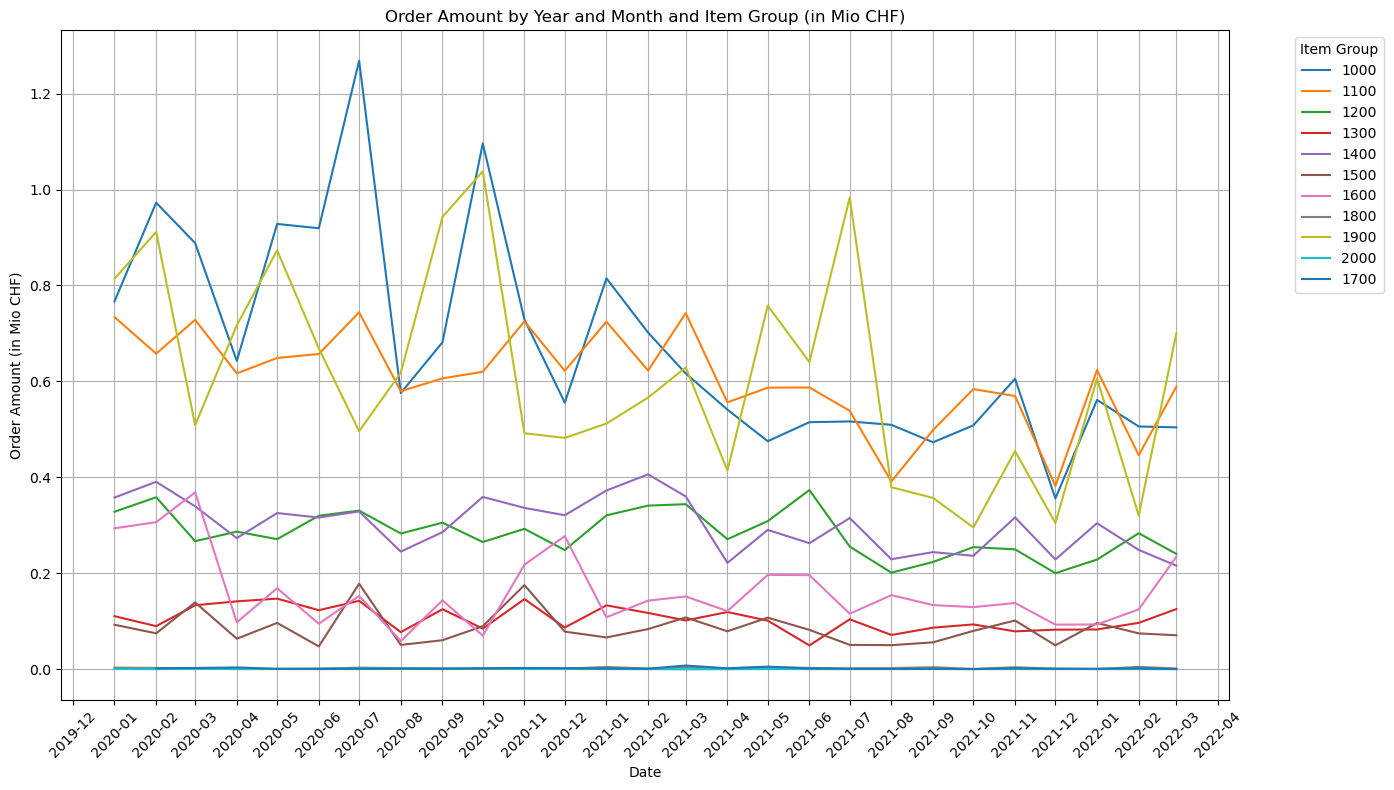

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Angenommen, `result` ist bereits vorhanden und enthält die Spalte 'Date' und 'MioOrderAmountCHF'
# Es wird davon ausgegangen, dass 'Date' bereits als Datumsobjekt vorliegt

# Set up the plot
plt.figure(figsize=(14, 8))

# Iterate over each item group and plot the lines
for itemgroup in result['Itemgroup'].unique():
    group_data = result[result['Itemgroup'] == itemgroup]
    plt.plot(group_data['Date'], group_data['MioOrderAmountCHF'], label=itemgroup)

# Add titles and labels
plt.title('Order Amount by Year and Month and Item Group (in Mio CHF)')
plt.xlabel('Date')
plt.ylabel('Order Amount (in Mio CHF)')

# Format the x-axis to show the year and month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Monatlicher Locator
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format als Jahr-Monat

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(title='Item Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a grid
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [32]:
sc.stop()

24/06/30 10:15:11 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/spark-6a72daae-c222-4097-a140-c519f2f9146c. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/spark-6a72daae-c222-4097-a140-c519f2f9146c
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:177)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:113)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1231)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4(ShutdownHookManager.scala:65)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4$adapted(ShutdownHookManager.scala:62)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(Array